# Explainer notebook

GitHub: https://github.com/Valdehh/CSS_Group_4

Webpage: https://valdehh.github.io/CSS_Group_4/

Contributions: We have been collaburating equally on all of the parts.

by: Andreas Rahbek-Palm (s214598) and Valdemar Hee Hansen (s214621)

## Motivation

-	What is our dataset ?

Our dataset contains the 1509 most popular GitHub repositories in deep-learning and machine learning, Based on GitHubs own stargazer count. from these repositories we have collected tags, descriptions, readme files and contributors. Furthermore, we have collected all of the company names filled out by the GitHub.

-	Why did you choose this/these particular dataset(s)?

As we are studying AI and within the last few years were introduced to this academic landscape, we found it interesting to investigate the most popular building blocks which helped shape landscape, before we properly enter it. Furthermore, were interested in finding out the properties of set network to gain insights in the potential flow of information and investigate its nature.

-	What was your goal for the end user’s experience?

To gain insight into the properties of contributor network for most rated depositories. To gain knowledge about trends and flows of information between the contributors of these repositories. But also to have a webpage that draws conclussions based on strong analytic evidence with illustrations to provide a visual experience, and that the user easily can navigate the webpage to find the desired content.


In [3]:
from joblib import Parallel, delayed
from tqdm import tqdm
from nltk.tokenize import word_tokenize, MWETokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import bigrams
from collections import Counter, defaultdict
from scipy.stats import chi2_contingency
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from langdetect import detect
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import networkx as nx
import netwulf as nw
import requests
import base64
import json
import nltk
import time
import ast
import re

## Basic stats. Let’s understand the dataset better

Get top repositories

To use the code a personal headers file is needed, which is not included in the repository. The headers file contains our personal API keys.

In [4]:
# Load the headers from the JSON file
with open('headers.json', 'r') as f:
    headers = json.load(f)

In [ ]:
def page_request(page, params, headers):
    """
    Send a request to the GitHub API and return the response.

    Args:
        page (int): The page number to request.
        params (dict): The parameters to include in the request.
        headers (dict): The headers to include in the request.

    Returns:
        repositories (list): A list of repositories from the response.
    """

    # Initialize an empty list to store the repositories
    repositories = []

    # Set the url and page parameter
    base_url = 'https://api.github.com/search/repositories'
    params['page'] = page

    # Send a GET request to the GitHub API
    response = requests.get(base_url, params=params, headers=headers)
    response.raise_for_status()  # Check for errors

    # Add the repositories from this page to the list
    repositories.extend(response.json()['items'])

    return repositories

In [ ]:
params = {
    'q': 'stars:>1 topic:machine-learning',  # Search for repositories with more than 1 star and the topic "machine-learning"
    'sort': 'stars',  # Sort by the number of stars
    'order': 'desc',  # Order in descending order (most stars first)
    'per_page': 100,  # Get 100 results per page
}

output = Parallel(n_jobs=4)(delayed(page_request)(page, params, headers) for page in tqdm(range(1, 11)))

In [ ]:
params = {
    'q': 'stars:>1 topic:machine-learning',  # Search for repositories with more than 1 star and the topic "machine-learning"
    'sort': 'stars',  # Sort by the number of stars
    'order': 'desc',  # Order in descending order (most stars first)
    'per_page': 100,  # Get 100 results per page
}

output2 = Parallel(n_jobs=4)(delayed(page_request)(page, params, headers) for page in tqdm(range(1, 11)))

Isolate unique repositories

In [ ]:
repositories = [item for sublist in output for item in sublist]
len(repositories)

repositories2 = [item for sublist in output2 for item in sublist]
len(repositories2)

combine = repositories + repositories2
print(len(combine))

description = []
# check the unique number of repositories
unique_repositories = []
seen_ids = set()

for repo in combine:
    if repo['id'] not in seen_ids:
        unique_repositories.append(repo)
        seen_ids.add(repo['id'])

print(len(unique_repositories))

In [ ]:
name = []
full_name = []
for repo in unique_repositories:
    name.append(repo['name'])
    full_name.append(repo['full_name'])

df_name = pd.DataFrame()
df_name['name'] = name[:len(name)-1]
df_name['full_name'] = full_name[:len(name)-1]

# save the dataframe
df_name.to_csv('repositories_name.csv', index=False)

Get the contributors

In [ ]:
def get_contributors(repo):  
    """
    Function for getting the contributors and additional information from a repository.

    Args:
        repo (dict): A dictionary representing a repository.
    
    Returns:
        all_contributors (list): A list of contributors.
        topics (list): A list of topics.
        description (list): A list of descriptions.
        stargazers_count (list): A list of stargazers count.
        company (list): A list of companies.
    """
    
    # Initialize the lists
    topics = []
    description = []
    stargazers_count = []
    company = []
    c = []
    
    # check if in unique repositories
    c.append(repo['owner']['login'])
    
    topics.append(repo['topics'])
    description.append(repo['description'])
    stargazers_count.append(repo['stargazers_count']) 

    url = f"https://api.github.com/repos/{repo['owner']['login']}/{repo['name']}/contributors"
    
    all_contributors = []
    page = 1

    while True:
        response = requests.get(url + '?page=' + str(page), headers=headers)
        
        # If the request was successful
        if response.status_code == 200:
            contri = response.json()
            
            if not contri:
                break
            i = 0
            while i < len(contri):
                
                contributor = contri[i]
                c.append(contributor['login'])
                user_response = requests.get(contributor['url'], headers=headers)
                if user_response.status_code == 200:
                    user = user_response.json()
                    if 'company' in user:
                        company.append(user['company'])
                    else:
                        company.append('None')
                    i += 1  # Increment the index

                elif user_response.status_code == 403:  # Rate limit exceeded
                    reset_time = int(user_response.headers['X-RateLimit-Reset'])  # Get the time when the rate limit will reset
                    sleep_time = max(reset_time - time.time(), 0)  # Calculate how long to sleep
                    print(f'Rate limit exceeded. Sleeping for {sleep_time} seconds.')
                    time.sleep(sleep_time)  # Sleep until the rate limit resets

            page += 1
        
        elif response.status_code == 403:  # Rate limit exceeded
            reset_time = int(response.headers['X-RateLimit-Reset'])  # Get the time when the rate limit will reset
            sleep_time = max(reset_time - time.time(), 0)  # Calculate how long to sleep
            print(f'Rate limit exceeded. Sleeping for {sleep_time} seconds.')
            time.sleep(sleep_time)  # Sleep until the rate limit resets
            continue  # Try the request again
        else:
            break
    
    all_contributors.append(c)

    return all_contributors, topics, description, stargazers_count, company

In [ ]:
# Get the contributors for each repository
output = Parallel(n_jobs=4)(delayed(get_contributors)(repo) for repo in tqdm(unique_repositories))

In [ ]:
contri = []
topics = []
description = []
stargazers_count = []
company = []

for i in range(len(output)):
    contri.append(output[i][0][0])
    topics.append(output[i][1][0])
    description.append(output[i][2][0])
    stargazers_count.append(output[i][3][0])
    company.append(output[i][4][0])

print(len(contri))

Get the owners of the repositories

In [ ]:
company = []
contributor = []
url = "https://api.github.com/users/"

for i in tqdm(range(len(output))):
    for j in range(len(output[i][4])):
        if j == 0:
            while True:
                # add code to make api call about output[i][0][0][j]
                url ="https://api.github.com/users/"+ output[i][0][0][j]
                user_response = requests.get(url, headers=headers)
                if user_response.status_code==200:
                    company.append(user_response.json()['company'])
                    break
                elif user_response.status_code == 403:  # Rate limit exceeded
                    reset_time = int(user_response.headers['X-RateLimit-Reset'])  # Get the time when the rate limit will reset
                    sleep_time = max(reset_time - time.time(), 0)  # Calculate how long to sleep
                    time.sleep(sleep_time)  # Sleep until the rate limit resets
        
        elif output[i][4][j] == None:
            company.append("No Org")
        else:
            company.append(output[i][4][j])
        
        contributor.append(output[i][0][0][j])
        

In [ ]:
print(len(company))
print(len(contributor))

In [ ]:
df = pd.DataFrame()
df['contributors'] = contri
df['topics'] = topics
df['description'] = description
df['stargazers_count'] = stargazers_count

df.to_csv('repositories.csv', index=False)

contri_df = pd.DataFrame({
    'Contributor': contributor,
    'Company': company
})

contri_df['Company'][contri_df['Company'].isna()] = "No Org"


contri_df.to_csv('contributors.csv', index=False)

df.head()  # Display the first few rows of the DataFrame

In [6]:
df_contributors = pd.read_csv('contributors.csv')
df_repositories = pd.read_csv('repositories.csv')

Ensure df list elements are list and that there are no duplicates

In [14]:
df_contributors = df_contributors.drop_duplicates('Contributor')

df_repositories["contributors"] = df_repositories["contributors"].apply(ast.literal_eval)
df_repositories['topics'] = df_repositories['topics'].apply(ast.literal_eval)

In [15]:
# If company is "No Org", then inset identity key
identity_key_generator = iter(range(1, len(df_contributors) + 1))
df_contributors['Company'] = df_contributors['Company'].apply(lambda x: str(next(identity_key_generator)) if x == "No Org" else x)

# Display the first few rows
display(df_contributors)

# Expand the contributors list
df_repositories_expanded = df_repositories.explode('contributors')

# Display the first few rows
display(df_repositories_expanded.head())

# Merge the repositories and contributors dataframes
df_merged = pd.merge(df_repositories_expanded, df_contributors, left_on='contributors', right_on='Contributor', how='left')

# Drop the 'Contributor' column and rename the 'contributors' column and 'Company' column
df_merged = df_merged.drop(columns=['Contributor'])
df_merged = df_merged.rename(columns={'contributors': 'contributor'})
df_merged = df_merged.rename(columns={'Company': 'company'})

# Display the first few rows
display(df_merged.head())

# Print the shape of all dataframes
print(f"Contributors: {df_contributors.shape}")
print(f"Repositories: {df_repositories.shape}")
print(f"Repositories Expanded: {df_repositories_expanded.shape}")
print(f"Merged: {df_merged.shape}")

,Contributor,Company
0,tensorflow,1
1,tensorflower-gardener,Google
2,ezhulenev,Google
3,mihaimaruseac,2
4,yongtang,Google
...,...,...
69763,Li-Hongcheng,30331
69764,AlvinIsonomia,30332
69766,Armandolando,重庆大学
69767,lokinko,University of Virginia


,contributors,topics,description,stargazers_count
0,tensorflow,"[deep-learning, deep-neural-networks, distribu...",An Open Source Machine Learning Framework for ...,182566
0,tensorflower-gardener,"[deep-learning, deep-neural-networks, distribu...",An Open Source Machine Learning Framework for ...,182566
0,ezhulenev,"[deep-learning, deep-neural-networks, distribu...",An Open Source Machine Learning Framework for ...,182566
0,mihaimaruseac,"[deep-learning, deep-neural-networks, distribu...",An Open Source Machine Learning Framework for ...,182566
0,yongtang,"[deep-learning, deep-neural-networks, distribu...",An Open Source Machine Learning Framework for ...,182566


,contributor,topics,description,stargazers_count,company
0,tensorflow,"[deep-learning, deep-neural-networks, distribu...",An Open Source Machine Learning Framework for ...,182566,1
1,tensorflower-gardener,"[deep-learning, deep-neural-networks, distribu...",An Open Source Machine Learning Framework for ...,182566,Google
2,ezhulenev,"[deep-learning, deep-neural-networks, distribu...",An Open Source Machine Learning Framework for ...,182566,Google
3,mihaimaruseac,"[deep-learning, deep-neural-networks, distribu...",An Open Source Machine Learning Framework for ...,182566,2
4,yongtang,"[deep-learning, deep-neural-networks, distribu...",An Open Source Machine Learning Framework for ...,182566,Google


Contributors: (52570, 2)
Repositories: (1509, 4)
Repositories Expanded: (71331, 4)
Merged: (71331, 5)


 Process company collumn

In [16]:
# slight processing of company to try and fix most comman issues

df_merged['company'] = df_merged['company'].astype(str)

df_merged['company'] = df_merged['company'].str.replace('Inc','')

df_merged['company'] = df_merged['company'].str.replace('https://github.com/','')

df_merged['company'] = df_merged['company'].str.replace('\'','')

df_merged['company'] = df_merged['company'].str.replace('[^\w\s]','')

df_merged['company'] = df_merged['company'].apply(lambda x: 'google' if 'google' in x.lower() else x.lower())

df_merged['company'] = df_merged['company'].apply(lambda x: 'facebook' if 'facebook' in x.lower() else x.lower())

df_merged['company'] = df_merged['company'].apply(lambda x: x.encode("ascii", "ignore").decode())

df_merged['company'] = df_merged['company'].str.replace(' ','')

df_merged['company'] = df_merged['company'].str.replace('@','')

df_merged['company'] = df_merged['company'].apply(lambda x: 'tensorflow' if 'tensorflow' in x.lower() else x.lower())

df_dict = df_merged.set_index('contributor')['company'].to_dict()

Create adj list

In [17]:
adj_list2 = defaultdict(int)
count_of_total_contributors = 0
for row in df_repositories.iterrows():
    # check if in unique repositories
    # For each pair of contributors
    for i in range(len(row[1]['contributors'])):
        for j in range(i + 1, len(row[1]['contributors'])):
            # Get the logins of the contributors
            login1 = row[1]['contributors'][i]
            login2 = row[1]['contributors'][j]
            adj_list2[(login1, login2)] += 1
            count_of_total_contributors += 1
        
# print max value of the pair
max_value = max(adj_list2.values())
print(f"Max value: {max_value}")
print(min(adj_list2.values()))
# avarage value
print(f"avarage value: {sum(adj_list2.values())/len(adj_list2)}")

Max value: 47
1
avarage value: 1.0206376746107915


### Graph using all nodes

In [18]:
# Create a graph
G = nx.Graph()

weighted_edge_list = [(u, v, d) for (u, v), d in adj_list2.items() if d > 1]

G.add_weighted_edges_from(weighted_edge_list)

nx.set_node_attributes(G, df_dict, 'company')

# get uniqie companies in the graph using G
companies = set(nx.get_node_attributes(G, 'company').values())
print(f"Number of companies: {len(companies)}")

Number of companies: 17349


basic network analysis - with bot

In [19]:
# Total number of nodes (authors)
num_nodes = G.number_of_nodes()

# Total number of links (collaborations)
num_edges = G.number_of_edges()

# Network's density
density = nx.density(G)

# Check if the network is fully connected
is_connected = nx.is_connected(G)

# Number of connected components
num_connected_components = nx.number_connected_components(G)

# Number of isolated nodes
num_isolated_nodes = nx.number_of_isolates(G)

# largest connected component
largest_cc = max(nx.connected_components(G), key=len)

In [20]:
print(f"Number of nodes: {num_nodes}")
print(f"Number of edges: {num_edges}")
print(f"Density: {density}")
print(f"Is the network fully connected? {'Yes' if is_connected else 'No'}")
print(f"Number of connected components: {num_connected_components}")
print(f"Number of isolated nodes: {num_isolated_nodes}")
print(f"largest connected component: {len(largest_cc)}")

weights = [data['weight'] for u, v, data in G.edges(data=True)]

# Calculate the maximum, minimum, and average weight
max_weight = max(weights)
min_weight = min(weights)
avg_weight = sum(weights) / len(weights)

print(f"Maximum weight: {max_weight}")
print(f"Minimum weight: {min_weight}")
print(f"Average weight: {avg_weight}")

Number of nodes: 22318
Number of edges: 122304
Density: 0.0004911108963892978
Is the network fully connected? No
Number of connected components: 164
Number of isolated nodes: 0
largest connected component: 21647
Maximum weight: 47
Minimum weight: 2
Average weight: 2.059033228676086


In [21]:
# avarage degree
degree = dict(G.degree())
avg_degree = sum(degree.values()) / len(degree)
print(f"Average degree: {avg_degree}")

Average degree: 10.960121874719958


In [22]:
print(f'The top 10 highest degree nodes are: {sorted(degree.items(), key=lambda x: x[1], reverse=True)[:10]}')

The top 10 highest degree nodes are: [('dependabot[bot]', 2344), ('tensorflow', 501), ('seriousran', 472), ('kHarshit', 454), ('AUTOMATIC1111', 429), ('jlevy44', 429), ('kianelbo', 419), ('gwang111', 417), ('DexGroves', 410), ('vlad17', 399)]


In [23]:
# Compute the propability p for the Computational Social Scientists network
num_nodes = len(G.nodes)
num_edges = len(G.edges)
p = num_edges / (num_nodes * (num_nodes - 1) / 2)
print(f'number of nodes: {num_nodes} and number of edges: {num_edges}')
print(f'The edge probability for the Computational Social Scientists network is {p}')

Gr = nx.erdos_renyi_graph(num_nodes, p)

number of nodes: 22318 and number of edges: 122304
The edge probability for the Computational Social Scientists network is 0.0004911108963892978


In [26]:
degree = dict(G.degree())
degree_randomr = dict(Gr.degree())

avarage_degree = np.mean(list(degree.values())) 
avarage_degree_randomr = np.mean(list(degree_randomr.values()))

print(f'The average degree of github collabaration network {avarage_degree}')
print(f'The average degree of the Random Network is {avarage_degree_randomr}')

max_degree = max(degree, key=degree.get)
max_degree_randomr = max(degree_randomr, key=degree_randomr.get)

print(f'The node with the highest degree in the github collabaration network is {max_degree} with a degree of {degree[max_degree]}')
print(f'The node with the highest degree in the Random Network is {max_degree_randomr} with a degree of {degree_randomr[max_degree_randomr]}')
print(f'Top 3 highest degree nodes in the github collabaration network are: {sorted(degree.items(), key=lambda x: x[1], reverse=True)[:3]}')

The average degree of github collabaration network 10.960121874719958
The average degree of the Random Network is 11.014786271171252
The node with the highest degree in the github collabaration network is dependabot[bot] with a degree of 2344
The node with the highest degree in the Random Network is 81 with a degree of 26
Top 3 highest degree nodes in the github collabaration network are: [('dependabot[bot]', 2344), ('tensorflow', 501), ('seriousran', 472)]


number of nodes with degree 1: 15182
number of nodes with degree 2: 1379


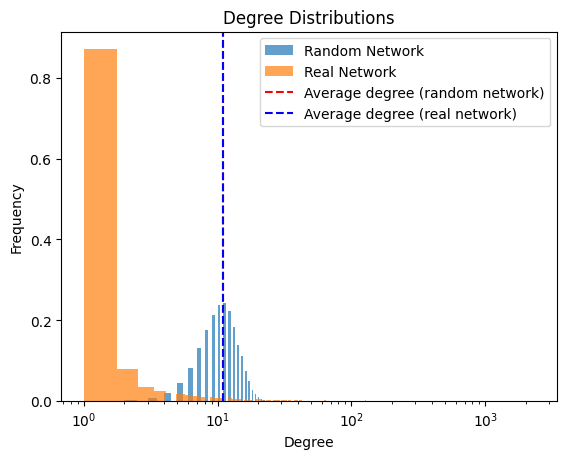

In [25]:
# Compute the degree distribution for the Computational Social Scientists network
degrees_real = [degree for node, degree in G.degree()]

print(f'number of nodes with degree 1: {len([degree for degree in degrees_real if degree == 1])}')
print(f'number of nodes with degree 2: {len([degree for degree in degrees_real if degree == 2])}')

# Compute the degree distribution for the random network
degrees_random = [degree for node, degree in Gr.degree()]

# Plot the degree distributions
plt.figure()
plt.hist(degrees_random, bins=50, density=True ,alpha=0.7, label='Random Network')
plt.hist(degrees_real, bins=3*10**3, density=True, alpha=0.7, label='Real Network')

# Add vertical lines for the average degrees
plt.axvline(np.mean(degrees_random), color='r', linestyle='--', label='Average degree (random network)')
plt.axvline(np.mean(degrees_real), color='b', linestyle='--', label='Average degree (real network)')

# log scale the x-axis
plt.xscale('log')
plt.legend()
plt.title('Degree Distributions')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.show()

### Graph without BOT

In [28]:
# remove bot node and edge from the network (node with most degree)
GB = G.copy()
GB.remove_node(max_degree)

# Do the same analysis
num_nodes = GB.number_of_nodes()
num_edges = GB.number_of_edges()
density = nx.density(GB)
is_connected = nx.is_connected(GB)
num_connected_components = nx.number_connected_components(GB)
num_isolated_nodes = nx.number_of_isolates(GB)
largest_cc = max(nx.connected_components(GB), key=len)

print(f"Number of nodes: {num_nodes}")
print(f"Number of edges: {num_edges}")
print(f"Density: {density}")
print(f"Is the network fully connected? {'Yes' if is_connected else 'No'}")
print(f"Number of connected components: {num_connected_components}")
print(f"Number of isolated nodes: {num_isolated_nodes}")
print(f"largest connected component: {len(largest_cc)}")

# Compute the propability p for the Computational Social Scientists network
num_nodes = len(GB.nodes)
num_edges = len(GB.edges)
p = num_edges / (num_nodes * (num_nodes - 1) / 2)
print(f'number of nodes: {num_nodes} and number of edges: {num_edges}')
print(f'The edge probability for the Computational Social Scientists network is {p}')

Grb = nx.erdos_renyi_graph(num_nodes, p)

degree = dict(GB.degree())
degree_randomrm = dict(Grb.degree())

degree_list_real = list(degree.values())
degree_list_random = list(degree_randomrm.values())

Number of nodes: 22317
Number of edges: 119960
Density: 0.0004817417507126513
Is the network fully connected? No
Number of connected components: 370
Number of isolated nodes: 193
largest connected component: 21401
number of nodes: 22317 and number of edges: 119960
The edge probability for the Computational Social Scientists network is 0.0004817417507126513


In [29]:
avarage_degree = np.mean(list(degree.values())) 
avarage_degree_randomrm = np.mean(list(degree_randomrm.values()))

print(f'The average degree of github collabaration network {avarage_degree}')
print(f'The average degree of the Random Network is {avarage_degree_randomrm}')

max_degree = max(degree, key=degree.get)
max_degree_randomrm = max(degree_randomrm, key=degree_randomrm.get)

print(f'The node with the highest degree in the github collabaration network is {max_degree} with a degree of {degree[max_degree]}')
print(f'The node with the highest degree in the Random Network is {max_degree_randomrm} with a degree of {degree_randomrm[max_degree_randomrm]}')
print(f'Top 3 highest degree nodes in the github collabaration network are: {sorted(degree.items(), key=lambda x: x[1], reverse=True)[:3]}')

The average degree of github collabaration network 10.750548908903527
The average degree of the Random Network is 10.771788322803244
The node with the highest degree in the github collabaration network is tensorflow with a degree of 500
The node with the highest degree in the Random Network is 8599 with a degree of 26
Top 3 highest degree nodes in the github collabaration network are: [('tensorflow', 500), ('seriousran', 471), ('kHarshit', 453)]


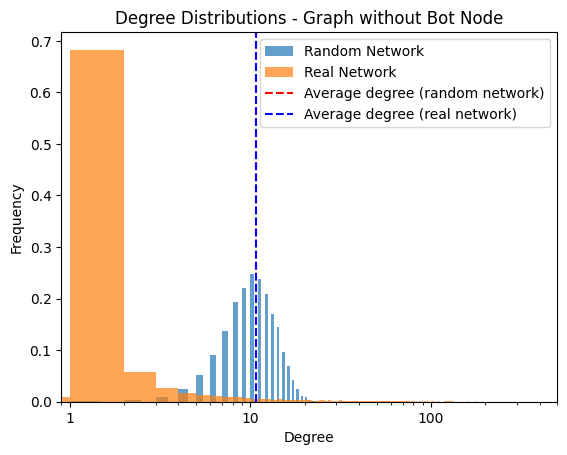

In [30]:
plt.figure()
plt.hist(degree_list_random, bins=50, density=True ,alpha=0.7, label='Random Network')
plt.hist(degree_list_real, bins=5*10**2, density=True, alpha=0.7, label='Real Network')

# Add vertical lines for the average degrees
plt.axvline(np.mean(degree_list_random), color='r', linestyle='--', label='Average degree (random network)')
plt.axvline(np.mean(degree_list_real), color='b', linestyle='--', label='Average degree (real network)')

# log scale the x-axis
plt.xscale('log')

# Set xticks to only integers
plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))

# Set x-axis limits
plt.xlim([0.9, max(max(degree_list_random), max(degree_list_real))])

plt.legend()
plt.title('Degree Distributions - Graph without Bot Node')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.savefig('degree_distribution.png')
plt.show()

## Questions

-	**Write about your choices in data cleaning and preprocessing**

Filter tags for machine learning and deep learning to only get relevant repositories, we also ensured that these repositories was the most popular using order in the params of the api call. 

Company document was full of people writing in companies different ways so we attempted to make them more alike by removing symbols and delete the most common differences.

We remove duplicates and remove people who does not have collaborations with unique users in multiple repositories. This is done as we are interested in the We remove duplicates and remove people who does not have collaborations with unique users in multiple repositories. This is done as we are interested in the collaborations patterns across repositories.

For the text analysis part we have filtered out all non-English repositories since we are not able to analyze multiple languages at a time. We have also removed all the stop words to get a more usefull analysis which can discover the topics of the repositories. Additionally, the README.md files are cleaned from HTML syntax, markdownsyntax, symbols, number, etc. to make the text analysis focus solely on word tokens.


- **Discusses of the dataset stats**


The networks were created by applying a threshold of 2 so any user most have 2 unique collaborations with another to link them. This was done to ensure that the users collaborate more frequently with each other and have a stronger connection. Furthermore, we are not interested in collaboration in a single repository as it is not a strong connection.

Based on the simple analysis we found depenada bot which helps maintaining repositories this was the largest node by far with 2344 links and the second largest being tensorflow with 501. Therefore we exclueded it and created a graph without for the webpage as it is not a real user and a great outlier which corrupts the graph.

For the graph without the Bot we have a network of:

- **Number of nodes:** 22317

- **Number of edges:** 119960

- **Density:** 0.0004817417507126513

Based on the first few stats we can see that we really have a giant network of contributors, which illustrate an eagerness to participate and help drive the research.

- **Is the network fully connected?** No

- **Number of connected components:** 370

- **Number of isolated nodes:** 193

- **largest connected component:** 21401

Here we see that the 193 people have most likely only been in contributing to 2 networks where no other contributor than the dependa bot is consistent. This is fairly impressive as it is a fraction of the network which illustrates that people most likely work together with the same users in numerous projects. Furthermore, we have a giant network component of approximately 96% of the network, which alludes to broad collaboration.

- **The average degree of github collabaration network** 10.750548908903527

- **The node with the highest degree in the github collabaration network is tensorflow with a degree of** 500

- **Top 3 highest degree nodes in the github collabaration network are:** [('tensorflow', 500), ('seriousran', 471), ('kHarshit', 453)]

The top 3 with most collaborations is an industrial account **tensorflow** while the others are active ML developers. It is surprising that developers has been able to significantly contribute to so many repositories, we were expecting more organizational accounts in the top repositories.

The degree distribution is a heavy tail which is typical for these social networks and has attributes such as being scale-invariant.

This data is **ready made** as it is not something "intended" for analytics, for example data points are missing as half of the users have not put any company or have written it in various ways.

## Tools, theory and analysis. Describe the process of theory to insight.

Tools theory and analysis will be descriped after they have been performed

### Assorsativity

### Graph  BOT

In [31]:
# degree and attribute assortativity
degree_correlation = nx.degree_assortativity_coefficient(G)
attribute_correlation = nx.attribute_assortativity_coefficient(G, 'company')

print(f'Degree Assortativity: {degree_correlation}')
print(f'Attribute Assortativity: {attribute_correlation}')

Degree Assortativity: -0.06601548277529869
Attribute Assortativity: 0.012344043684619445


In [32]:
def configuration_model(G: nx.Graph, num_swaps: int):
    """
    Function to generate a configuration model of a given network.

    Args:
        G: nx.Graph, Network to consider
        num_swaps: int, Number of edge swaps to perform
    
    Returns:
        G_new: nx.Graph, Configuration model of the network
    """
    
    # Create an exact copy of the original network
    G_new = G.copy()

    # Perform edge swaps
    G_new = nx.double_edge_swap(G_new, nswap=num_swaps, max_tries=num_swaps*2)

    degree_assortativity = nx.degree_assortativity_coefficient(G_new)
    
    assorsativity = nx.attribute_assortativity_coefficient(G_new, 'company')

    return G_new, degree_assortativity, assorsativity

In [33]:

print(f'The degree assortativity coefficient for the github collaboration network is {nx.degree_assortativity_coefficient(G)}')

num_edges = G.number_of_edges()
num_networks = 100

# use tqdm and parallel to run congifuration model
output = Parallel(n_jobs=4)(delayed(configuration_model)(G, num_edges * 10) for _ in tqdm(range(num_networks)))

The degree assortativity coefficient for the github collaboration network is -0.06601548277529869


100%|██████████| 100/100 [1:18:42<00:00, 47.23s/it]


In [34]:
degree_assortativity_config = []
attribute_assortativity_config = []
for i in range(len(output)):
    degree_assortativity_config.append(output[i][1])
    attribute_assortativity_config.append(output[i][2])
    

print(f'lenght of degree_assortativity_config: {len(degree_assortativity_config)}')
print(f'lenght of attribute_assortativity_config: {len(attribute_assortativity_config)}')

lenght of degree_assortativity_config: 100
lenght of attribute_assortativity_config: 100


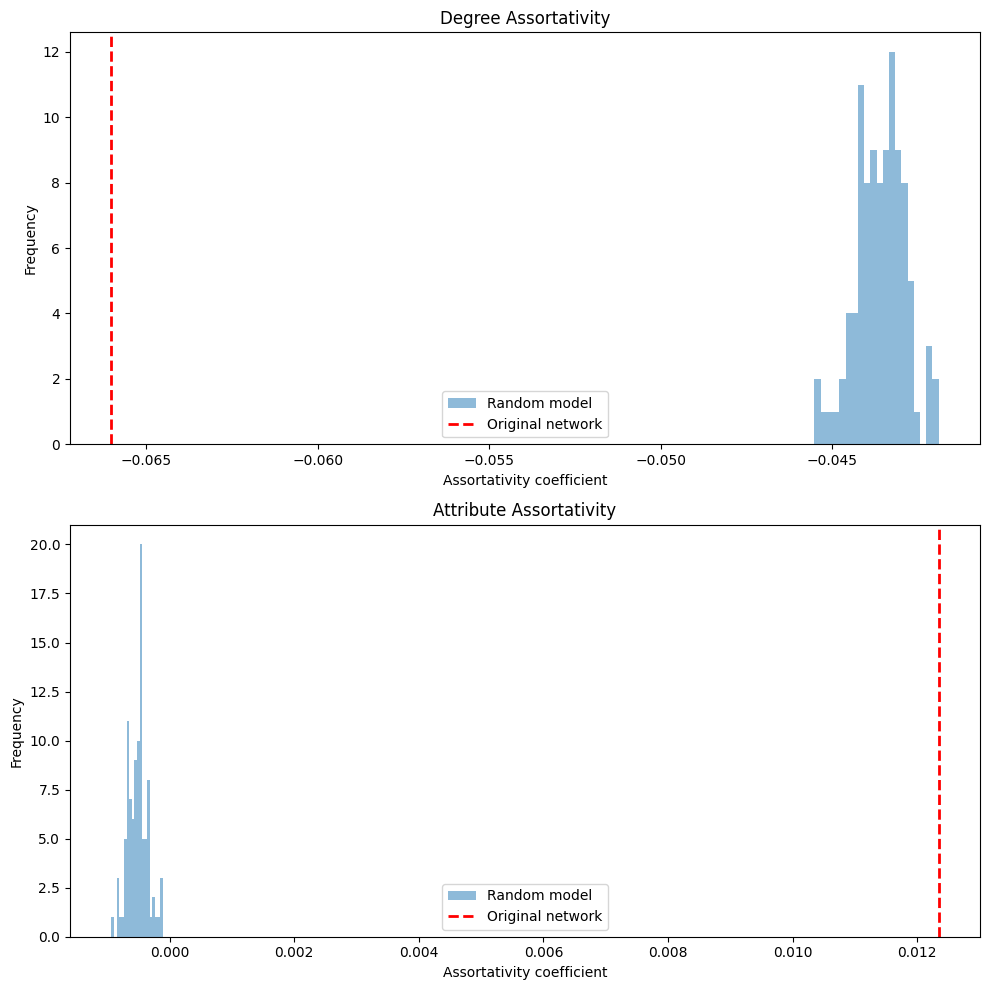

In [35]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Plot Degree Assortativity
axs[0].hist(degree_assortativity_config, bins=20, alpha=0.5, label='Random model')
axs[0].axvline(degree_correlation, color='r', linestyle='dashed', linewidth=2, label='Original network')
axs[0].set_xlabel('Assortativity coefficient')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Degree Assortativity')
axs[0].legend()

# Plot Attribute Assortativity
axs[1].hist(attribute_assortativity_config, bins=20, alpha=0.5, label='Random model')
axs[1].axvline(attribute_correlation, color='r', linestyle='dashed', linewidth=2, label='Original network')
axs[1].set_xlabel('Assortativity coefficient')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Attribute Assortativity')
axs[1].legend()

# Adjust layout for better spacing
fig.tight_layout()

plt.show()

### Graph without BOT

In [36]:
degree_correlation = nx.degree_assortativity_coefficient(GB)
attribute_correlation = nx.attribute_assortativity_coefficient(GB, 'company')

print(f'Degree Assortativity: {degree_correlation}')
print(f'Attribute Assortativity: {attribute_correlation}')

Degree Assortativity: -0.0561675332112954
Attribute Assortativity: 0.012647451293536787


In [37]:
num_edges = GB.number_of_edges()
num_networks = 100

# use tqdm and parallel to run congifuration model
output = Parallel(n_jobs=4)(delayed(configuration_model)(GB, num_edges * 10) for _ in tqdm(range(num_networks)))

100%|██████████| 100/100 [1:15:13<00:00, 45.13s/it]


lenght of degree_assortativity_config: 100
lenght of attribute_assortativity_config: 100


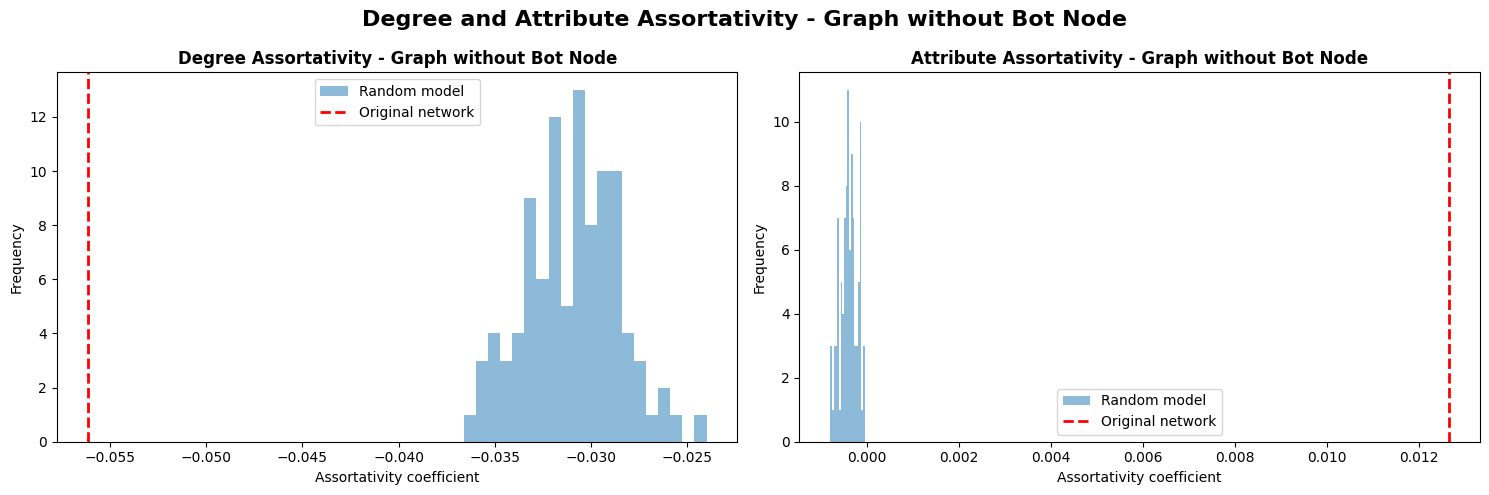

In [38]:
degree_assortativity_config_B = []
attribute_assortativity_config_B = []
for i in range(len(output)):
    degree_assortativity_config_B.append(output[i][1])
    attribute_assortativity_config_B.append(output[i][2])
    

print(f'lenght of degree_assortativity_config: {len(degree_assortativity_config_B)}')
print(f'lenght of attribute_assortativity_config: {len(attribute_assortativity_config_B)}')


fig, axs = plt.subplots(1, 2, figsize=(15, 5))

fig.suptitle('Degree and Attribute Assortativity - Graph without Bot Node', fontsize=16, weight='bold')

# Plot Degree Assortativity
axs[0].hist(degree_assortativity_config_B, bins=20, alpha=0.5, label='Random model')
axs[0].axvline(degree_correlation, color='r', linestyle='dashed', linewidth=2, label='Original network')
axs[0].set_xlabel('Assortativity coefficient')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Degree Assortativity - Graph without Bot Node', fontsize=12, weight='bold')
axs[0].legend()

# Plot Attribute Assortativity
axs[1].hist(attribute_assortativity_config_B, bins=20, alpha=0.5, label='Random model')
axs[1].axvline(attribute_correlation, color='r', linestyle='dashed', linewidth=2, label='Original network')
axs[1].set_xlabel('Assortativity coefficient')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Attribute Assortativity - Graph without Bot Node', fontsize=12, weight='bold')
axs[1].legend()

# Adjust layout for better spacing
fig.tight_layout()
plt.savefig('degree_attribute_assortativity.png')
plt.show()


**Assorsativity by degree:**

Is a metric calculated based on correlation of degrees between pairs of connected nodes in a network. The metric defined from -1 to 1 which indicates tendencies of nodes with the same degree connecting. If the metric is negative, there are tendencies of high degree nodes combining with low and vice versa. If the metric is 0 it is random if a small node is connected to a specific degree node. If it is positive nodes with the same degree tends to connect.

This metric is used to get valuable insight in the structure of the network and can help us understand the network.

**Assorsativity by attribute:**

Is based on probabilities that a randomly chosen edge connects two nodes of the same attribute, the difference between the actual fraction of edges that connect nodes of the same attribute and the expected fraction of such edges in a random graph and divided by the max number this difference can give. This metric is also between -1 and 1. Again negative value indicates people with the same attribute is likely to not connect. 0 indicates randomness and positive means that people with the same attribute is more likely to connect.

this metric was used to investigate if the people from the same company connect.


**Configuration models:**

These models are made from swapping the edges between random pairs of nodes (u-v x-y) of the network. Hereby, the network still has it attributes and are closer to the real network than binomial based network would be. As we always connect u and x and v and y, to ensure that there is no bias the algorithm used here always selects two random nodes (u and x) and then from their links selects a random second node (v and y). 

This was used to investigate significance  when computing assorsativity.


### Clustering

### Graph without BOT

In [39]:
clustering_coefficient = nx.average_clustering(GB)
clustering_coefficient_random = nx.average_clustering(Grb)

print(f'The clustering coefficient of the github collaboration network is {clustering_coefficient}')
print(f'The clustering coefficient of the Random Network is {clustering_coefficient_random}')
random_clustering = []
for i in tqdm(range(100)):
    # generate a random network
    GrCluster = nx.erdos_renyi_graph(num_nodes, p)
    random_clustering.append(nx.average_clustering(GrCluster))

print(f'The average clustering coefficient of the Random Network is {np.mean(random_clustering)}')
print(f'The standard deviation of the clustering coefficient of the Random Network is {np.std(random_clustering)}')

The clustering coefficient of the github collaboration network is 0.1900569094208709
The clustering coefficient of the Random Network is 0.0004528087669131215


100%|██████████| 100/100 [25:02<00:00, 15.02s/it]

The average clustering coefficient of the Random Network is 0.00047914897543550915
The standard deviation of the clustering coefficient of the Random Network is 3.6595690898873775e-05


**Clustering:**

Is calculated for each node in the graph, the function identifies its neighbors and uses the connections between the neighbor’s vs the possible connections between neighbors. The value is between 0 and 1. 0 being no clusters at all and 1 being all the neighbors are connected to each other. 

We used this average to find the structure of the graph being hieratical. 

**Random networks**

Generation of random networks was made based on the likelihood of a node being connected to another. We made this using binomial distribution. 

This was used to see if the clustering was significant. 



### Shortest Path

### Graph with BOT

In [40]:
# largest component of the network
largest_cc = max(nx.connected_components(G), key=len)
largest_cc_random = max(nx.connected_components(Gr), key=len)

# Create subgraphs
largest_cc_subgraph = G.subgraph(largest_cc)
largest_cc_random_subgraph = Gr.subgraph(largest_cc_random)

print(f'The largest connected component of the github collaboration network has {len(largest_cc)} nodes')
print(f'The largest connected component of the Random Network has {len(largest_cc_random)} nodes')

# see avarage shortest path
shortest_path = nx.average_shortest_path_length(largest_cc_subgraph)
shortest_path_random = nx.average_shortest_path_length(largest_cc_random_subgraph)

print(f'The average shortest path length of the github collaboration network is {shortest_path}')
print(f'The average shortest path length of the Random Network is {shortest_path_random}')

The largest connected component of the github collaboration network has 21647 nodes
The largest connected component of the Random Network has 22318 nodes
The average shortest path length of the github collaboration network is 4.4517211375979375
The average shortest path length of the Random Network is 4.448351734953925


### Graph without bot

In [41]:
# largest component of the network
largest_cc = max(nx.connected_components(GB), key=len)
largest_cc_random = max(nx.connected_components(Grb), key=len)

# Create subgraphs
largest_cc_subgraph = GB.subgraph(largest_cc)
largest_cc_random_subgraph = Grb.subgraph(largest_cc_random)

print(f'The largest connected component of the github collaboration network has {len(largest_cc)} nodes')
print(f'The largest connected component of the Random Network has {len(largest_cc_random)} nodes')

# see avarage shortest path
shortest_path = nx.average_shortest_path_length(largest_cc_subgraph)
shortest_path_random = nx.average_shortest_path_length(largest_cc_random_subgraph)

print(f'The average shortest path length of the github collaboration network is {shortest_path}')
print(f'The average shortest path length of the Random Network is {shortest_path_random}')

The largest connected component of the github collaboration network has 21401 nodes
The largest connected component of the Random Network has 22317 nodes
The average shortest path length of the github collaboration network is 4.877578779400212
The average shortest path length of the Random Network is 4.484150158277224


**Shortest path average**

Shortest path is simply connected to the shortest path from a node to any other node in the graph. This was computed for the giant component as the graph has to be fully connected.

The average was used to see if the small world principle was upheld and to illustrate interconnectivity.  


### illustrate network and random network

These has not been run as the plots has to be tweaked locally hosted webpage and are therefore hard to directly recreate

In [ ]:
stylized_network = nw.get_filtered_network(G,node_group_key='company')
stylized_network, config = nw.visualize(stylized_network)
# illustrative example of the network stylized_network
nw.draw_netwulf(stylized_network)

In [ ]:
stylized_network = nw.get_filtered_network(G)
stylized_network, config = nw.visualize(stylized_network)
# illustrative example of the network stylized_network
nw.draw_netwulf(stylized_network)

In [ ]:
stylized_network = nw.get_filtered_network(Gr)
stylized_network, config = nw.visualize(stylized_network)
# illustrative example of the network stylized_network
nw.draw_netwulf(stylized_network)

In [ ]:
stylized_network = nw.get_filtered_network(GB,node_group_key='company')
stylized_network, config = nw.visualize(stylized_network)
# illustrative example of the network stylized_network
nw.draw_netwulf(stylized_network)

## Text

Get the readme files for the repositories

In [7]:
def get_readme_from_repo(repo):
    """Get the README from a repository.
    
    Args:
        repo (dict): A dictionary containing information about the repository.
    
    Returns:
        dict: A dictionary containing the repository name and the raw README content.
    """

    # Get the README URL
    readme_url = f"https://api.github.com/repos/{repo['full_name']}/readme"

    # Send a GET request to the README URL
    readme_response = requests.get(readme_url, headers=headers)
    
    # If the status code is 403, we have reached the rate limit
    while readme_response.status_code == 403:
        reset_time = int(readme_response.headers['X-RateLimit-Reset'])
        sleep_time = max(reset_time - time.time() + 1, 0)  # Add one second to be sure the rate limit has been reset
        time.sleep(sleep_time)
        readme_response = requests.get(readme_url, headers=headers)
    
    # If the status code is 200, we have successfully retrieved the README
    if readme_response.status_code == 200:
        readme_content = base64.b64decode(readme_response.json()['content']).decode("utf-8")
    
    # If the status code is 404, the README does not exist
    elif readme_response.status_code == 404:
        readme_content = None
    
    # If the status code is not 403, 200 or 404
    else:
        readme_content = None
    
    return {'full_name': repo['full_name'], 'readme_raw': readme_content, 'status_code': readme_response.status_code}

In [8]:
# Get the READMEs from the repositories
readme_results = Parallel(n_jobs=4)(delayed(get_readme_from_repo)(repo) for repo in tqdm(df_repositories.to_dict('records')))

  0%|          | 0/1509 [00:00<?, ?it/s]

100%|██████████| 1509/1509 [01:29<00:00, 16.78it/s]


Create dataframe and check if all the readmes are acquired

In [9]:
# Create a dataframe from the results
df_readmes = pd.DataFrame(readme_results)

# Display the first few rows
display(df_readmes.head())

# Check if there are any missing READMEs
missing_readmes = df_readmes['readme_raw'].isnull().sum()
print(f"Number of missing READMEs: {missing_readmes}")

# Count the number of each status codes
status_codes = df_readmes['status_code'].value_counts()
print(status_codes)

,full_name,readme_raw,status_code
0,tensorflow/tensorflow,"<div align=""center"">\n <img src=""https://www....",200
1,huggingface/transformers,<!---\nCopyright 2020 The HuggingFace Team. Al...,200
2,pytorch/pytorch,![PyTorch Logo](https://github.com/pytorch/pyt...,200
3,netdata/netdata,"\n<p align=""center"">\n<a href=""https://www.net...",200
4,microsoft/ML-For-Beginners,[![GitHub license](https://img.shields.io/gith...,200


Number of missing READMEs: 0
200    1509
Name: status_code, dtype: int64


In [10]:
# Merge the READMEs with the repositories
df_repositories_readme = pd.merge(df_repositories, df_readmes, left_on='full_name', right_on='full_name', how='inner')

# Print the shape of the dataframes before and the combined after
print(f"The of the dataframes before are {df_repositories.shape} for the repositories dataframe and {df_readmes.shape} for the readme dataframe.")
print(f"The merged dataframe is {df_repositories_readme.shape}")

The of the dataframes before are (1509, 6) for the repositories dataframe and (1509, 3) for the readme dataframe.
The merged dataframe is (1509, 8)


Save the complete dataset

In [11]:
# Save the merged dataframe to a CSV file
df_repositories_readme.to_csv('repositories_readme.csv', index=False)

Preprocess the raw README.md files from the repositories. When the README.md files are requested and parsed through the GitHub API, the files are returned in raw markdown format containing some HTML entities. The raw markdown files are then preprocessed to remove any markdown or HTML syntax and to extract the text content from the files.

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\valde\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\valde\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

We cannot work with repositories whos README.md contain language other than English. We will remove those repositories from the dataset.

In [ ]:
def is_english(text):
    """
    Check if the text is in English.
    
    Args:
        text (str): The text to check.
    
    Returns:
        bool: True if the text is in English, False otherwise.
    """

    if not isinstance(text, str):
        return False
    
    return detect(text) == 'en'

In [ ]:
# Remove non english repositories
df_repositories_readme_english = df_repositories_readme[df_repositories_readme['readme_raw'].apply(is_english)]
df_repositories_readme_english = df_repositories_readme_english.reset_index(drop=True)
print(f"Number of English repositories: {len(df_repositories_readme_english)}")

Number of English repositories: 1453


The README.md files are more complex to clean than the abstracts from the papers that we worked on in the course. The README.md files contain more code snippets, URLs, and other special characters that need to be removed. The README.md files further more contain HTML and markdown syntax that need to be removed.

In [ ]:
def clean_text(text: str):
    """
    Clean the text by removing markdown syntax, html syntax, URLs, special characters, digit, and more.
    
    Args:
        text (str): The text to clean.
    
    Returns:
        text (str): The cleaned text.
    """
    
    if not isinstance(text, str):
        return ''

    # Remove all text within angle brackets
    text = re.sub(r'<.*?>', '', text)
    
    # Remove all text within square brackets
    text = re.sub(r'\[.*?\]', '', text)
    
    # Remove all text within parentheses
    text = re.sub(r'\(.*?\)', '', text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove HTML entities
    text = re.sub(r'&[a-z]+;', '', text)
    
    # Remove Markdown syntax
    text = re.sub(r'[_*#-]', '', text)
    
    # Remove code blocks
    text = re.sub(r'```.*?```', '', text, flags=re.DOTALL)
    
    # Remove inline code
    text = re.sub(r'`.*?`', '', text)
    
    # Remove numbers, mathematical symbols and punctuation
    text = re.sub(r'\w*\d\w*', '', text)
    text = re.sub(r'[^A-Za-z\s]', '', text)
    
    # Convert text to lowercase
    text = text.lower()

    return text

In [ ]:
# Apply the function to the 'readme_raw' column
df_repositories_readme_english['readme_clean'] = df_repositories_readme_english['readme_raw'].apply(clean_text)

Now we want to tokenize the clean text. We will tokenize the text both with and without stopwords included. We remove the stopwords from the text since they are not informative for the analysis that we want to perform afterwards.

In [ ]:
def tokenize_text(text: str):
    """
    Clean the readme.md file and tokenize the text.

    Args:
        text (str): The text to tokenize and clean.

    Returns:
        list: A list of cleaned and tokenized words.
    """

    if not isinstance(text, str):
        return []
    
    # Tokenize text
    tokens = word_tokenize(text)
    
    # Stem the tokens
    tokens = [token for token in tokens]
    
    return tokens

def tokenize_text_no_stopwords(text: str):
    """
    Clean the readme.md file, tokenize the text, and remove stopwords.

    Args:
        text (str): The text to tokenize and clean.

    Returns:
        list: A list of cleaned and tokenized words.
    """

    if not isinstance(text, str):
        return []
    
    # Tokenize text
    tokens = word_tokenize(text)
    
    # Stem the tokens
    tokens = [token for token in tokens if token not in stopwords.words('english')]
    
    return tokens

In [ ]:
# Apply the function to the 'readme_raw' column
df_repositories_readme_english['tokens'] = df_repositories_readme_english['readme_clean'].apply(tokenize_text)
df_repositories_readme_english['tokens_no_stopwords'] = df_repositories_readme_english['readme_clean'].apply(tokenize_text_no_stopwords)

# Display the tokens for the first repository
print(df_repositories_readme_english['tokens'].iloc[0])
print(df_repositories_readme_english['tokens_no_stopwords'].iloc[0])

['is', 'an', 'endtoend', 'open', 'source', 'platform', 'for', 'machine', 'learning', 'it', 'has', 'a', 'comprehensive', 'flexible', 'ecosystem', 'of', 'and', 'resources', 'that', 'lets', 'researchers', 'push', 'the', 'stateoftheart', 'in', 'ml', 'and', 'developers', 'easily', 'build', 'and', 'deploy', 'mlpowered', 'applications', 'tensorflow', 'was', 'originally', 'developed', 'by', 'researchers', 'and', 'engineers', 'working', 'within', 'the', 'machine', 'intelligence', 'team', 'at', 'google', 'brain', 'to', 'conduct', 'research', 'in', 'machine', 'learning', 'and', 'neural', 'networks', 'however', 'the', 'framework', 'is', 'versatile', 'enough', 'to', 'be', 'used', 'in', 'other', 'areas', 'as', 'well', 'tensorflow', 'provides', 'stable', 'and', 'apis', 'as', 'well', 'as', 'a', 'nonguaranteed', 'backward', 'compatible', 'api', 'for', 'keep', 'uptodate', 'with', 'release', 'announcements', 'and', 'security', 'updates', 'by', 'subscribing', 'to', 'see', 'all', 'the', 'install', 'see', '

The following code stems the tokens that we just computed. Due to how the stemmer works on certain words and not being able to find a better stemmer, we have decided to not use the stemmed tokens in this project. We are aware that this is the reason that we later on get both "model" and "models" in the analysis. This is not the only case of two words being identical if stemmed but just an example.

In [ ]:
def stem_tokens(tokens):
    """
    Stem a list of tokens.
    
    Args:
        tokens (list): A list of tokens.
    
    Returns:
        list: A list of stemmed tokens.
    """

    # Initialize the stemmer
    stemmer = PorterStemmer()
    
    # Stem the tokens
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    
    return stemmed_tokens

In [47]:
# Apply the function to the 'tokens' column
df_repositories_readme_english['tokens_stemmed'] = df_repositories_readme_english['tokens'].apply(stem_tokens)
df_repositories_readme_english['tokens_stemmed_no_stopwords'] = df_repositories_readme_english['tokens_no_stopwords'].apply(stem_tokens)

# Display the tokens for the first repository
print(df_repositories_readme_english['tokens_stemmed'].iloc[0])
print(df_repositories_readme_english['tokens_stemmed_no_stopwords'].iloc[0])

['is', 'an', 'endtoend', 'open', 'sourc', 'platform', 'for', 'machin', 'learn', 'it', 'ha', 'a', 'comprehens', 'flexibl', 'ecosystem', 'of', 'and', 'resourc', 'that', 'let', 'research', 'push', 'the', 'stateoftheart', 'in', 'ml', 'and', 'develop', 'easili', 'build', 'and', 'deploy', 'mlpower', 'applic', 'tensorflow', 'wa', 'origin', 'develop', 'by', 'research', 'and', 'engin', 'work', 'within', 'the', 'machin', 'intellig', 'team', 'at', 'googl', 'brain', 'to', 'conduct', 'research', 'in', 'machin', 'learn', 'and', 'neural', 'network', 'howev', 'the', 'framework', 'is', 'versatil', 'enough', 'to', 'be', 'use', 'in', 'other', 'area', 'as', 'well', 'tensorflow', 'provid', 'stabl', 'and', 'api', 'as', 'well', 'as', 'a', 'nonguarante', 'backward', 'compat', 'api', 'for', 'keep', 'uptod', 'with', 'releas', 'announc', 'and', 'secur', 'updat', 'by', 'subscrib', 'to', 'see', 'all', 'the', 'instal', 'see', 'the', 'for', 'the', 'to', 'use', 'a', 'and', 'to', 'instal', 'the', 'current', 'releas', 

In the following sections when we consider the text analysis, we have not used any groupings like communities, since groups within collaborator network are not usefull for dividing the repositories into groups.

The following section is a short analysis of the 20 most frequent tokens (no stopwords) across all README.md files. The analysis is done to get an understanding of the most common words in the README.md files.

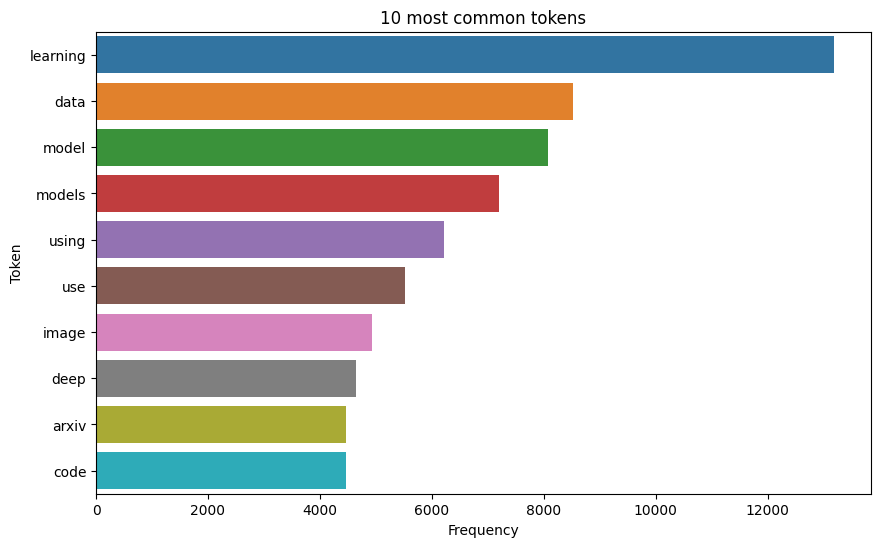

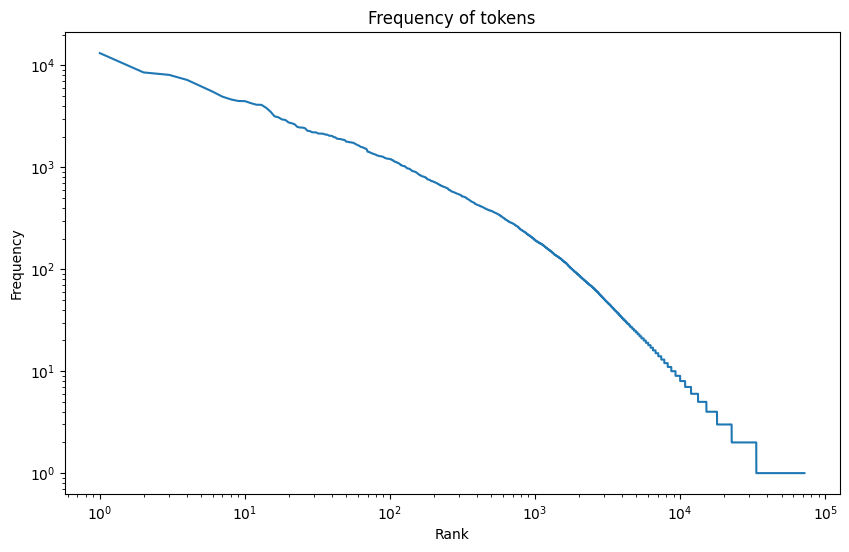

In [ ]:
# Create a list of all tokens
all_tokens = df_repositories_readme_english['tokens_no_stopwords'].sum()

# Count the frequency of each token
token_counts = Counter(all_tokens)

# Sort the tokens by frequency
tokens, frequencies = zip(*token_counts.most_common())

# Get the 10 most common tokens
most_common_tokens = tokens[:10]
most_common_frequencies = frequencies[:10]

# Plot the 10 most common tokens
plt.figure(figsize=(10, 6))
sns.barplot(x=list(most_common_frequencies), y=list(most_common_tokens))
plt.xlabel('Frequency')
plt.ylabel('Token')
plt.title('10 most common tokens')
plt.show()

# Plot the frequencies against the ranks (log-log plot)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(frequencies) + 1), frequencies)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Rank')
plt.ylabel('Frequency')
plt.title('Frequency of tokens')
plt.show()

The log-log plot of rank versus frequency for all the tokens is created to illustrate that the token distribution upholds Zipf's law. In this context, "rank" is the position of each token when the tokens are sorted by their frequency, with the most frequent token ranked 1.Furthermore, Zipf's Law is an empirical law that states that the frequency of a token is inversely proportional to its rank. This means that the most frequent word will occur approximately twice as often as the second most frequent word, three times as often as the third most frequent word, etc. Therefore, if the log-log plot of rank versus frequency is fairly linear the distribution of the tokens follows Zipf's law.

This next section computes the bigrams (ignoring stopwords and their place in the original text) for each README.md file. The bigrams are are computed two find collocations in the text. A collocation is two tokens that appear together often enough to be considered as a single token. To do this we compute a $2 \times 2$ contingency table for all bigrams, based on the $2 \times 2$ contingency table a $\chi^2$ test is performed. If the bigram has a frequency of more than 50 and a $\chi^2$ p-value of more less than $0.001$, the bigram is considered a collocation.

In [ ]:
def compute_bigrams(tokens):
    """
    Compute bigrams from a list of tokens.
    
    Args:
        tokens (list): A list of tokens.
    
    Returns:
        list: A list of bigrams.
    """

    # Compute bigrams
    bigram_tokens = list(bigrams(tokens))
    
    return bigram_tokens

In [ ]:
# Apply the function to the 'tokens' column
df_repositories_readme_english['bigrams'] = df_repositories_readme_english['tokens_no_stopwords'].apply(compute_bigrams)

# Display the bigrams for the first repository
print(df_repositories_readme_english['bigrams'].iloc[0])

# Create a list of all bigrams
all_bigrams = df_repositories_readme_english['bigrams'].sum()

# Find all the tokens that appear in the bigrams
tokens_in_bigrams = [token for bigram in all_bigrams for token in bigram]

# Count the frequency of each bigram
bigram_counts = Counter(all_bigrams)

# Count the frequency of each token in the bigrams
token_counts_in_bigrams = Counter(tokens_in_bigrams)

# Compute the Chi-squared statistics and p-value for each bigram
bigram_chi2 = {}
for bigram, count in bigram_counts.items():
    word1, word2 = bigram
    count_word1 = token_counts_in_bigrams[word1]
    count_word2 = token_counts_in_bigrams[word2]
    count_total = len(tokens_in_bigrams)
    expected_count = count_word1 * count_word2 / count_total
    contingency_table = [[count, count_word1 - count], [count_word2 - count, count_total - count_word1 - count_word2 + count]]
    chi2, p, _, expected_contingency_table = chi2_contingency(contingency_table)
    bigram_chi2[bigram] = (chi2, p)

# Find the bigrams that appear more than 50 times and have p-value smaller than 0.001
collocations = [bigram for bigram, (chi2, p) in bigram_chi2.items() if bigram_counts[bigram] > 50 and p < 0.001]

[('endtoend', 'open'), ('open', 'source'), ('source', 'platform'), ('platform', 'machine'), ('machine', 'learning'), ('learning', 'comprehensive'), ('comprehensive', 'flexible'), ('flexible', 'ecosystem'), ('ecosystem', 'resources'), ('resources', 'lets'), ('lets', 'researchers'), ('researchers', 'push'), ('push', 'stateoftheart'), ('stateoftheart', 'ml'), ('ml', 'developers'), ('developers', 'easily'), ('easily', 'build'), ('build', 'deploy'), ('deploy', 'mlpowered'), ('mlpowered', 'applications'), ('applications', 'tensorflow'), ('tensorflow', 'originally'), ('originally', 'developed'), ('developed', 'researchers'), ('researchers', 'engineers'), ('engineers', 'working'), ('working', 'within'), ('within', 'machine'), ('machine', 'intelligence'), ('intelligence', 'team'), ('team', 'google'), ('google', 'brain'), ('brain', 'conduct'), ('conduct', 'research'), ('research', 'machine'), ('machine', 'learning'), ('learning', 'neural'), ('neural', 'networks'), ('networks', 'however'), ('howe

The following section is to display the top 20 most frequent collocation that were found across README.md files for the repositories.

Number of collocations: 546


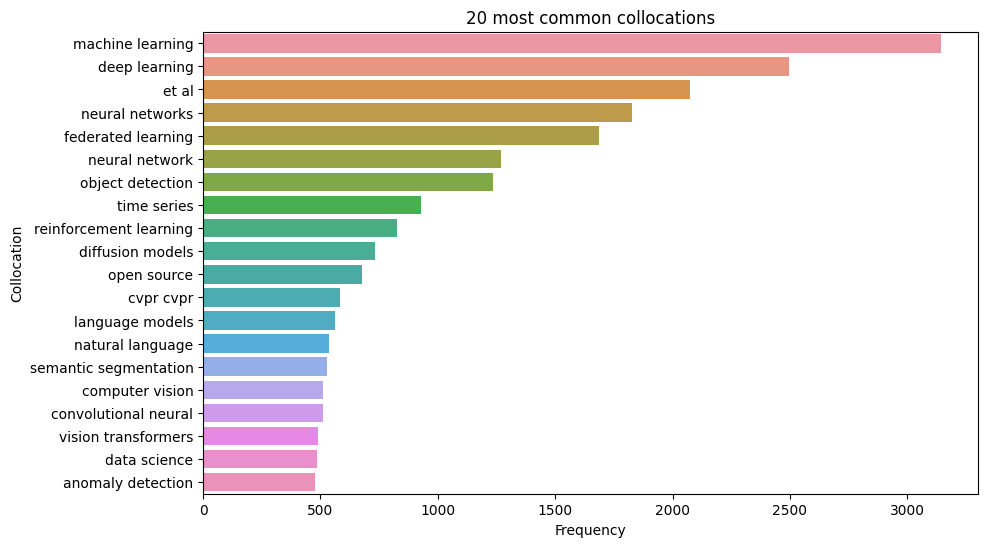

In [ ]:
# Count collocations and sort them by frequency
collocation_counts = {bigram: bigram_counts[bigram] for bigram in collocations}
collocations_sorted = sorted(collocation_counts, key=collocation_counts.get, reverse=True)

# Print the amount of collocations
print(f"Number of collocations: {len(collocations_sorted)}")

# Get the 20 most common collocations
most_common_collocations = collocations_sorted[:20]
most_common_collocation_counts = [collocation_counts[bigram] for bigram in most_common_collocations]

# Plot the 20 most common collocations
plt.figure(figsize=(10, 6))
sns.barplot(x=most_common_collocation_counts, y=[f"{bigram[0]} {bigram[1]}" for bigram in most_common_collocations])
plt.xlabel('Frequency')
plt.ylabel('Collocation')
plt.title('20 most common collocations')
plt.show()

From the plot we see that two topics that the repositories were filtered on appear namely _machine learning_ and _deep learning_. The third most frequent collocation is _et al_, which suggests that many of the repositories are related to scientific research. The rest of the collocations are mostly methods or model types, which is to be expected.

In the next section we tokenize the clean text once more, but this time we recognize all collocations as one token. This is done to perform further analysis on the tokens and collocations at the same time, and to see if some collocations are as descriptive as the most desciptive tokens. 

In [ ]:
def tokenize_text_mwe(text):
    """
    Clean the readme.md file, tokenize the text, and remove stopwords.
    Use the MWETokenizer to tokenize multi-word expressions.

    Args:
        text (str): The text to tokenize and clean.
    
    Returns:
        list: A list of cleaned and tokenized words.
    """

    # If the input is not a string, return an empty list
    if not isinstance(text, str):
        return []

    # Initialize the MWETokenizer with the most common collocations
    tokenizer = MWETokenizer(most_common_collocations, separator=' ')

    # Tokenize text
    tokens = tokenizer.tokenize(word_tokenize(text))
    
    # Stem the tokens
    tokens = [token for token in tokens if token not in stopwords.words('english')]
    
    return tokens

In [ ]:
# Apply the function to the 'readme_raw' column
df_repositories_readme_english['tokens_mwe'] = df_repositories_readme_english['readme_clean'].apply(tokenize_text_mwe)

# Display the tokens for the first repository
print(df_repositories_readme_english['tokens_mwe'].iloc[0])

['endtoend', 'open source', 'platform', 'machine learning', 'comprehensive', 'flexible', 'ecosystem', 'resources', 'lets', 'researchers', 'push', 'stateoftheart', 'ml', 'developers', 'easily', 'build', 'deploy', 'mlpowered', 'applications', 'tensorflow', 'originally', 'developed', 'researchers', 'engineers', 'working', 'within', 'machine', 'intelligence', 'team', 'google', 'brain', 'conduct', 'research', 'machine learning', 'neural networks', 'however', 'framework', 'versatile', 'enough', 'used', 'areas', 'well', 'tensorflow', 'provides', 'stable', 'apis', 'well', 'nonguaranteed', 'backward', 'compatible', 'api', 'keep', 'uptodate', 'release', 'announcements', 'security', 'updates', 'subscribing', 'see', 'install', 'see', 'use', 'install', 'current', 'release', 'includes', 'support', 'ubuntu', 'windows', 'devices', 'supported', 'using', 'smaller', 'cpuonly', 'package', 'also', 'available', 'update', 'tensorflow', 'latest', 'version', 'add', 'flag', 'commands', 'nightly', 'binaries', 'a

Now we want to display the most frequent tokens or collocations from across the README.md files.

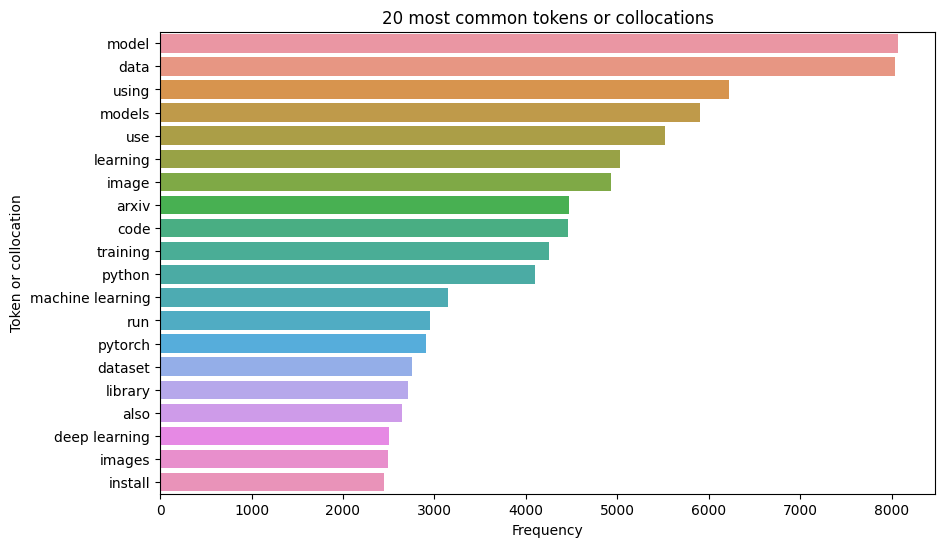

In [ ]:
# Create a list of all mwe tokens
all_tokens_mwe = df_repositories_readme_english['tokens_mwe'].sum()

# Count the frequency of each mwe token
token_counts_mwe = Counter(all_tokens_mwe)

# Sort the mwe tokens by frequency
tokens_mwe, frequencies_mwe = zip(*token_counts_mwe.most_common())

# Get the 20 most common mwe tokens
most_common_tokens_mwe = tokens_mwe[:20]
most_common_frequencies_mwe = frequencies_mwe[:20]

# Plot the 20 most common mwe tokens
plt.figure(figsize=(10, 6))
sns.barplot(x=list(most_common_frequencies_mwe), y=list(most_common_tokens_mwe))
plt.xlabel('Frequency')
plt.ylabel('Token or collocation')
plt.title('20 most common tokens or collocations')
plt.show()

From the plot we see that many of the expected basic terms from machine learning and deep learning appear with high frequencies. Most interestingly, we see that the two topics that the repositories were filtered on appear as the only two collocations among the top 20 tokens or collocations. Interestingly, arxiv appears as a token, which is a platform for scientific papers, and this might indicate that the repositories are often related to scientific research.

In [ ]:
# Print the columns of the dataframe
print(df_repositories_readme_english.columns)

# Save the dataframe to a CSV file
df_repositories_readme_english.to_csv('repositories_readme_tokens.csv', index=False)

Index(['contributors', 'topics', 'description', 'stargazers_count',
       'full_name', 'name', 'readme_raw', 'status_code', 'readme_clean',
       'tokens', 'tokens_no_stopwords', 'tokens_stemmed',
       'tokens_stemmed_no_stopwords', 'bigrams', 'tokens_mwe'],
      dtype='object')


In this next section we perform a TF-IDF analysis on the tokens and collocations. The TF-IDF analysis is performed to find the most important tokens or collocations across all README.md files. The TF-IDF analysis is performed by computing the term frequency (TF) and inverse document frequency (IDF) for each token or collocation. The TF is the frequency of a token or collocation in a single README.md file, while the IDF is the inverse of the frequency of the token or collocation across all README.md files. The TF-IDF score is the product of the TF and IDF scores, and the score is used to rank the tokens or collocations.

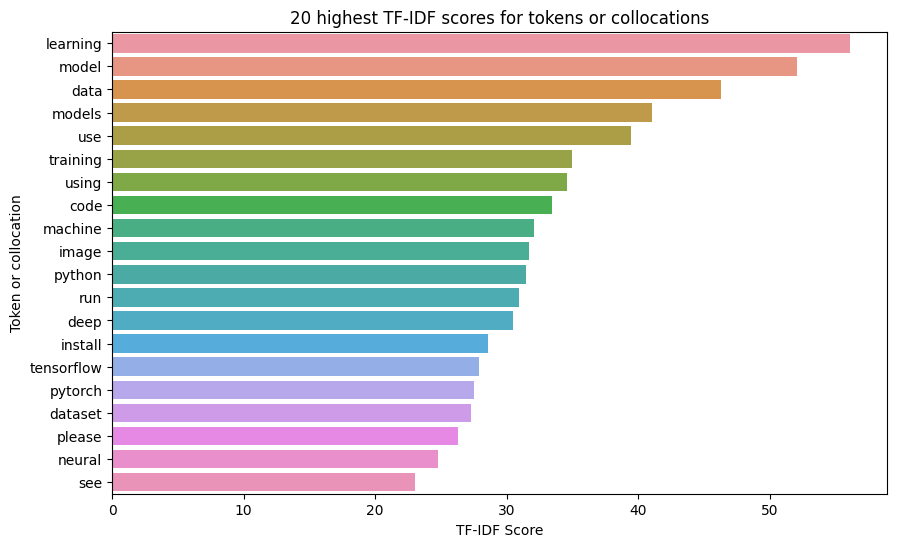

In [ ]:
# Convert the lists of tokens back to strings
tokens_mwe_str = df_repositories_readme_english['tokens_mwe'].apply(' '.join)

# Initialize the TfidfVectorizer
vectorizer = TfidfVectorizer()

# Compute the TF-IDF scores for 'tokens_mwe'
X = vectorizer.fit_transform(tokens_mwe_str)
feature_names = vectorizer.get_feature_names_out()
tfidf_scores_mwe = pd.Series(X.sum(axis=0).A1, index=feature_names)

# Get the 20 highest TF-IDF scores for 'tokens_mwe'
highest_tfidf_mwe = tfidf_scores_mwe.nlargest(20)

# Plot the 20 highest TF-IDF scores for 'tokens_mwe'
plt.figure(figsize=(10, 6))
sns.barplot(x=highest_tfidf_mwe, y=highest_tfidf_mwe.index)
plt.xlabel('TF-IDF Score')
plt.ylabel('Token or collocation')
plt.title('20 highest TF-IDF scores for tokens or collocations')
plt.show()

From the plot we see that many of the expected basic terms from machine learning and deep learning appear with high frequencies. Most interestingly, we see that the two topics that the repositories were filtered on appear as the only two collocations among the top 20 tokens or collocations. Interestingly, arxiv appears as a token, which is a platform for scientific papers, and this might indicate that the repositories are often related to scientific research.

In this next section we create a word cloud to display the 200 most prominent tokens or collocations across the README.md files. The size of the token or collocation corresponds to the TF-IDF score and in the spirit of the assignmnt the word cloud has also been masked by the GitHub icon.

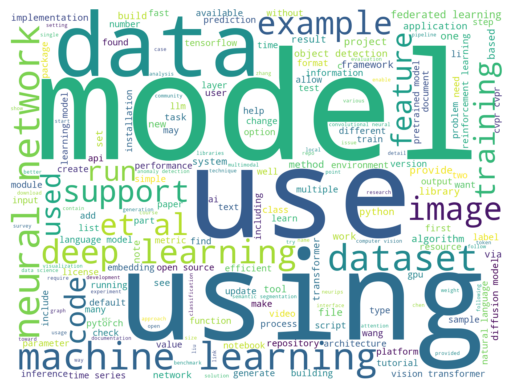

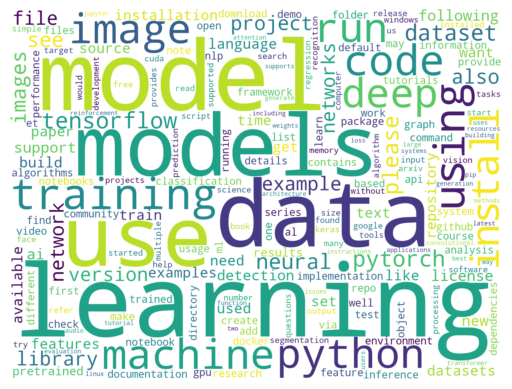

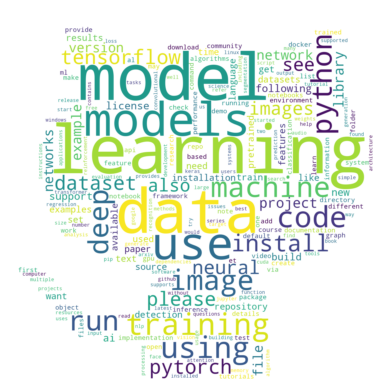

In [ ]:
# Convert github icon to a mask
github_icon = plt.imread('github_icon.png')
github_icon_mask = github_icon[:, :, 3]
github_icon_mask = 255 * github_icon_mask.astype(int)

# Create a WordCloud for the 'tokens_mwe' based on tf-idf scores
wordcloud = WordCloud(width=1600, height=1200, background_color="white").generate_from_frequencies(tfidf_scores_mwe.nlargest(200).to_dict())

# Display the WordCloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('wordcloud.png')
plt.show()

# Create a WordCloud for the 'tokens_mwe' based on tf-idf scores
wordcloud = WordCloud(width=1600, height=1600, background_color="white", mask=github_icon_mask).generate_from_frequencies(tfidf_scores_mwe.nlargest(200).to_dict())

# Display the WordCloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('wordcloud_github.png')
plt.show()

From the plot we see that the highest-scored tokens or collocations contain many of the same words as in tokens and collocations top 20 most frequent plot. Collocations are not as prominent anymore, but two of the largest repositories based on stars namely _tensorflow_ and _pytorch_ appear, which is logical since they are extremely popular modules. Additionally, more of the expected terms used in the field of machine learning and deep learning are quite prominent.

## Discussion. Think critically about your creation

- What went well?

Given the difficulties with the rate limit of the api we ended up getting the data needed for analysis. 

Analysis containing random networks and configuration models where significant even though the coefficients itself where rather low (due to the nature of the data) help us draw relevant conclusions on the network structure.

- What is still missing? What could be improved? Why?

Would have been nice with a better attribute to the different contributors then company - firstly as it is open source and many accounts are not work related and secondly due to the many missing companies. None the less a better processing of the company attribute would also have been good - however after viewing the data it really didint seem like it was fixable using NLP